In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!cp '/gdrive/My Drive/software/Unet_Pytorch/unet.py' unet.py

In [3]:
%cd /gdrive/My\ Drive/software/Unet_Pytorch/Data/

/gdrive/My Drive/software/Unet_Pytorch/Data


In [4]:
!pip install tensorboardX==1.9

     |████████████████████████████████| 194kB 6.7MB/s 


In [5]:
import tensorboard
print (tensorboard.__version__)

2.4.0


In [6]:
! pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 9.3MB/s 
     |████████████████████████████████| 634kB 12.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=bacb514f5770898dbf7c90540821c6425ef0ba225d121058abd492c15571ab23
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=77ab33a1a630ff3f528e35c75db9bbe5d0b4b039c7a1e27b08eec028308bbd66
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
import albumentations
albumentations.__version__

'0.4.5'

In [8]:
#Copying the supporting unte.py to the colab notebook runtime.

import sys
sys.path.append('/content')
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 23 11:34:15 2020

@author: vicenc
"""

#####################################################################################################################################3
#####################################################################################################################################3
# Parameters

# ---dataset

base_dir = '/gdrive/My Drive/software/Unet_Pytorch/Data/'
dataname='sardines'
experiment = 'experiment_final2'

# ---transforms parameters

patch_size_h = 576 
patch_size_v = 416 



# --- training params
batch_size=4
num_epochs =50
last_epoch = 35
edge_weight =1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do validation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels=3  #input channel of the data, RGB = 3
padding=True   #should convolution be padded (VALID)
depth=5       #depth of the network 
wf=6           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode='upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm =True #should we use batch normalization between the layers
ignore_index =-100 #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)

# --- loss function parameters

bce_weight = 0.2 # Binary Cross Entropy Loss
dice_loss_weight = 1-bce_weight # Dice Loss

#--- gpu identifier
gpuid = 0

In [10]:
#####################################################################################################################################3
#####################################################################################################################################3
# +
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from albumentations import *
from albumentations.pytorch import ToTensor




import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

import os

In [11]:
os.chdir(base_dir +'/'+dataname+'/'+experiment)

In [12]:
# Helper function for pretty printing of current time and remaining time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
# Check GPU availability 
print(torch.cuda.get_device_properties(gpuid))
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [14]:
#Carguem el model anterior

PATH= f"{dataname}_unet_model.pth"
model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
optim = torch.optim.Adam(model.parameters()) 

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_dict'])
optim.load_state_dict(checkpoint['optim_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [15]:
#Carguem el millor model anterior

PATH2= f"{dataname}_unet_best_model.pth"
model2 = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
checkpoint2 = torch.load(PATH2)
best_loss = checkpoint2['best_loss_on_test']

In [16]:
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	31043586


In [17]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,transforms=None , edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.transforms=transforms

        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        with tables.open_file(self.fname,'r') as db:
            self.img=db.root.img
            self.mask=db.root.mask
       
            #get the requested image and mask from the pytable
            img = self.img[index,:,:,:]
            mask = self.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        
        if self.transforms:
            augmented = self.transforms(image=img, masks=[mask,weight])
            img_new = augmented['image']
            mask_new,weight_new = augmented['masks']

            return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

In [18]:

#https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb
transforms = Compose([#VerticalFlip(p=.5),
       #HorizontalFlip(p=.5),
       HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       #RandomSizedCrop((patch_size_v,patch_size_v), patch_size_h,patch_size_h),
       ToTensor()])


In [19]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", transforms= transforms ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True)

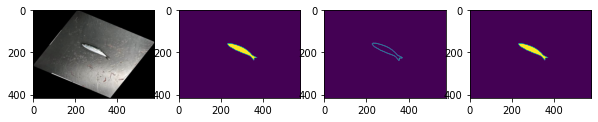

In [20]:
# +
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["train"][7]
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==1)
ax[2].imshow(patch_mask_weight)
ax[3].imshow(patch_mask)
# -

In [21]:
#####################################################################################################################################
# Define Optimizer

# Adam is going to be the faster, though perhaps not the best performing, typically a good place to start
optim = torch.optim.Adam(model.parameters()) 

# Alternativey try the SGD
#optim = torch.optim.SGD(model.parameters(),lr=.1, momentum=0.9, weight_decay=0.0005)

#####################################################################################################################################
# Weight individual classes

# We have the ability to weight individual classes,
# in this case we'll do so based on their presense in the training set
#to avoid biasing any particular class

nclasses = dataset["train"].numpixels.shape[1]
class_weight=dataset["train"].numpixels[1,0:2] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)
#show final used weights, make sure that they're reasonable before continuing
print(class_weight) 


#####################################################################################################################################
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index ,reduce=False) #reduce = False makes sure we get a 2D output instead of a 1D "summary" value


tensor([0.0843, 0.9157], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [22]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [23]:
%load_ext tensorboard

In [24]:
def dice_loss(prediction, y, smooth = 1.): #From https://github.com/usuyama/pytorch-unet
    prediction = prediction.contiguous()
    y = y.contiguous()    

    intersection = (prediction * y).sum().sum()
    
    loss = (1 - ((2. * intersection + smooth) / (prediction.sum().sum() + y.sum().sum() + smooth)))
    
    return loss.mean()


def dice_loss_2(prediction, y, smooth = 1.): #From https://discuss.pytorch.org/t/implementation-of-dice-loss/53552
    prediction = prediction.contiguous()
    y = y.contiguous()    

    iflat = prediction.contiguous().view(-1)
    tflat = y.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [ ]:

writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = best_loss["val"]
edge_weight=torch.tensor(edge_weight).to(device)
start_time = time.time()
print('%s ([%d/%d] %d%%), Train loss: %.4f Validation loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch, num_epochs ,(epoch) / num_epochs * 100, loss["train"], loss["val"]),end="")
for epoch in range(epoch,num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((2,2)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y_weight = y_weight.type('torch.FloatTensor').to(device)
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss_bce = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1  
                y_hot = F.one_hot(y, num_classes = n_classes).permute(0,3,1,2)#.contiguous() #in your case nb_classes = 2
                loss_dice =  dice_loss_2(prediction, y_hot)                
                
                
                loss = loss_bce * bce_weight + loss_dice * (1 - bce_weight)

                 #  If we need to debug and want to see the input, mask and prediction we can do:
                
                # The first index refers to the batch number [0 .. NBatches-1]
                
                #plt.imshow(X[0,0,:,:].cpu()) # This shows only the 1st Batch (0) and chanel Red
                #plt.imshow(y[0,:,:].cpu())
                #plt.imshow(prediction[0,1,:,:].detach().cpu().numpy()) #This shows the probability of a pixel to belong to the instance

                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()
          
                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)

    print('%s ([%d/%d] %d%%), Train loss: %.4f Validation loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


        torch.save(state, f"{dataname}_unet_best_model.pth")
    else:
        print("")
    state2 = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'loss': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


    torch.save(state2, f"{dataname}_unet_model.pth")    


0m 0s (- 0m 0s) ([24/50] 48%), Train loss: 0.0164 Validation loss: 0.0240

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


31m 47s (- 31m 47s) ([25/50] 50%), Train loss: 0.0162 Validation loss: 0.0236
61m 55s (- 57m 9s) ([26/50] 52%), Train loss: 0.0158 Validation loss: 0.0250
92m 7s (- 78m 28s) ([27/50] 54%), Train loss: 0.0158 Validation loss: 0.0252
122m 22s (- 96m 8s) ([28/50] 56%), Train loss: 0.0157 Validation loss: 0.0251
152m 36s (- 110m 30s) ([29/50] 57%), Train loss: 0.0156 Validation loss: 0.0237
182m 48s (- 121m 51s) ([30/50] 60%), Train loss: 0.0159 Validation loss: 0.0241
213m 13s (- 130m 40s) ([31/50] 62%), Train loss: 0.0156 Validation loss: 0.0246
243m 57s (- 137m 13s) ([32/50] 64%), Train loss: 0.0153 Validation loss: 0.0245
274m 40s (- 141m 29s) ([33/50] 66%), Train loss: 0.0153 Validation loss: 0.0251
305m 20s (- 143m 40s) ([34/50] 68%), Train loss: 0.0153 Validation loss: 0.0244
335m 44s (- 143m 52s) ([35/50] 70%), Train loss: 0.0150 Validation loss: 0.0255
366m 25s (- 142m 29s) ([36/50] 72%), Train loss: 0.0151 Validation loss: 0.0253
397m 2s (- 139m 29s) ([37/50] 74%), Train loss: 0.

In [ ]:
%tensorboard --logdir runs

In [ ]:
#@title Default title text
# +
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 
# -

#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [ ]:
checkpoint["model_dict"].keys()